# Notebook 05 — Error Analysis & Improvement Hypotheses

This notebook diagnoses where PPO underperforms relative to simple baselines on the **matched evaluation** from Sprint 4.

We focus on:
- **Where PPO loses** (symbol-level and episode-level)
- **Why PPO loses** (trend capture vs risk management vs earnings handling)
- **What to change next** (ranked, testable hypotheses for Sprint 5)

Outputs:
- A ranked table of “PPO failure modes”
- Concrete training changes to try next (reward shaping, features, action space, curriculum, hyperparams)
- A short interview-ready narrative: what we learned and what we did about it

## Setup: Imports and project paths

We import standard scientific Python libraries and locate the saved
evaluation artifacts from Notebook 3.

The notebook is robust to different working directories by discovering
the `episodes.json` file automatically under `runs/`.

In [1]:
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ROOT = Path.cwd().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

runs_dir = ROOT / "runs"
matches = list(runs_dir.glob("sprint4_generalization/notebook03_outputs/episodes.json"))

if not matches:
    # fallback search
    matches = list(runs_dir.rglob("notebook03_outputs/episodes.json"))

if not matches:
    raise FileNotFoundError("Could not find notebook03_outputs/episodes.json under runs/")

EPISODES_PATH = matches[0]
RUN_DIR = EPISODES_PATH.parent.parent  # .../runs/sprint4_generalization
OUT_DIR = RUN_DIR / "notebook05_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("EPISODES_PATH:", EPISODES_PATH)
print("RUN_DIR:", RUN_DIR)
print("OUT_DIR:", OUT_DIR)

ROOT: /home/btheard/projects/earningsedge-rl
EPISODES_PATH: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization/notebook03_outputs/episodes.json
RUN_DIR: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization
OUT_DIR: /home/btheard/projects/earningsedge-rl/runs/sprint4_generalization/notebook05_outputs


## Load matched evaluation records

Each record represents one policy run on a specific symbol and episode window.
Because all policies were evaluated on matched (symbol, seed) pairs,
these records allow fair, apples-to-apples comparison.

We validate:
- total episode count
- policy coverage
- required fields (equity curves, drawdowns, final equity)

In [3]:
with open(EPISODES_PATH, "r") as f:
    all_eps = json.load(f)

df = pd.DataFrame(all_eps)

# expected fields: policy, symbol, final_equity, max_drawdown, equity_curve, drawdown_curve
print("Total records:", len(df))
print("Policies:", sorted(df["policy"].unique()))
df.head(3)

Total records: 200
Policies: ['avoid_earnings', 'buy_hold', 'flat', 'ppo']


,policy,symbol,final_equity,max_drawdown,equity_curve,drawdown_curve
0,ppo,UAL,1.227342,0.146813,"[1.0, 1.0, 1.005968537163155, 1.00258490505511...","[0.0, 0.0, 0.0, 0.0033635565954996207, 0.00948..."
1,buy_hold,UAL,1.308803,0.198656,"[1.0, 0.994784409077498, 1.0071566167118493, 1...","[0.0, 0.005215590922496795, 0.0, 0.00672711319..."
2,flat,UAL,1.000000,0.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Validate evaluation schema

Before deeper analysis, we confirm:
- Required columns exist
- Numeric fields are properly typed
- Each policy has the same number of matched episodes

This prevents silent errors from propagating into diagnostics.

In [4]:
required = {"policy", "symbol", "final_equity", "max_drawdown", "equity_curve", "drawdown_curve"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in episodes.json: {missing}")

# Convert numeric columns
df["final_equity"] = df["final_equity"].astype(float)
df["max_drawdown"] = df["max_drawdown"].astype(float)

df.groupby("policy").size()

policy
avoid_earnings    50
buy_hold          50
flat              50
ppo               50
dtype: int64

## Derive diagnostic metrics from equity curves

Final equity alone is insufficient to explain behavior.
We extract interpretable signals from each equity curve, including:

- End equity (performance)
- Equity slope (trend capture)
- Volatility proxy (instability)
- Maximum drawdown depth (risk)

These metrics explain *how* PPO behaves, not just *what* it earns.

In [5]:
def max_equity(curve) -> float:
    return float(np.max(np.asarray(curve, dtype=float)))

def min_equity(curve) -> float:
    return float(np.min(np.asarray(curve, dtype=float)))

def end_equity(curve) -> float:
    return float(np.asarray(curve, dtype=float)[-1])

def volatility(curve) -> float:
    x = np.asarray(curve, dtype=float)
    r = np.diff(np.log(np.clip(x, 1e-12, None)))
    return float(np.std(r))

def slope(curve) -> float:
    x = np.asarray(curve, dtype=float)
    t = np.arange(len(x), dtype=float)
    # simple linear slope (trend proxy)
    return float(np.polyfit(t, x, 1)[0])

def drawdown_depth(dd_curve) -> float:
    # dd_curve should be >=0; if your env stores negative dd, take abs.
    dd = np.asarray(dd_curve, dtype=float)
    return float(np.max(dd))

In [6]:
diag = df.copy()
diag["eq_max"] = diag["equity_curve"].apply(max_equity)
diag["eq_min"] = diag["equity_curve"].apply(min_equity)
diag["eq_end"] = diag["equity_curve"].apply(end_equity)
diag["eq_slope"] = diag["equity_curve"].apply(slope)
diag["eq_vol"] = diag["equity_curve"].apply(volatility)
diag["dd_depth"] = diag["drawdown_curve"].apply(drawdown_depth)

diag[["policy","symbol","eq_end","eq_max","eq_min","eq_slope","eq_vol","dd_depth"]].head()

,policy,symbol,eq_end,eq_max,eq_min,eq_slope,eq_vol,dd_depth
0,ppo,UAL,1.227342,1.233426,0.971047,6.608384e-04,0.013735,0.146813
1,buy_hold,UAL,1.308803,1.424277,0.969156,9.638486e-04,0.017533,0.198656
2,flat,UAL,1.000000,1.000000,1.000000,-3.834155e-18,0.000000,0.000000
3,avoid_earnings,UAL,0.981273,1.157250,0.874650,-4.718066e-04,0.015106,0.244200
4,ppo,UAL,1.178760,1.324376,0.982757,3.990276e-05,0.019412,0.213664


## Align episodes across policies (pairing)

We build a pairing key (symbol + seed or start index) so PPO and baselines
are compared on identical market paths.

This removes randomness and ensures differences reflect policy behavior,
not different price histories.

In [7]:
pair_cols = ["symbol"]
for c in ["seed", "start_idx"]:
    if c in diag.columns:
        pair_cols.append(c)

def pair_key(row) -> tuple:
    return tuple(row[c] for c in pair_cols)

diag["pair_key"] = diag.apply(pair_key, axis=1)

print("Pair columns:", pair_cols)
print("Unique pairs:", diag["pair_key"].nunique())

Pair columns: ['symbol']
Unique pairs: 10


## Policy comparison on matched episodes

We reshape the data so each row represents one matched episode with
side-by-side PPO and baseline outcomes.

We compute:
- PPO − BuyHold final equity
- PPO − BuyHold drawdown improvement
- PPO − AvoidEarnings comparisons

This table is the core diagnostic surface of the notebook.

In [8]:
policies = ["ppo", "buy_hold", "flat", "avoid_earnings"]
for p in policies:
    if p not in set(diag["policy"].unique()):
        raise ValueError(f"Missing policy in data: {p}")

# pivot one row per pair_key with columns per policy
pivot = diag.pivot_table(
    index="pair_key",
    columns="policy",
    values=["final_equity", "max_drawdown", "eq_slope", "eq_vol"],
    aggfunc="first"
)

# flatten columns
pivot.columns = [f"{m}__{p}" for m, p in pivot.columns]
pivot = pivot.reset_index()

pivot["symbol"] = pivot["pair_key"].apply(lambda t: t[0])

# deltas: PPO vs baseline
pivot["delta_eq_vs_buyhold"] = pivot["final_equity__ppo"] - pivot["final_equity__buy_hold"]
pivot["delta_eq_vs_avoid"]   = pivot["final_equity__ppo"] - pivot["final_equity__avoid_earnings"]

# drawdown is "lower is better" so define improvement as baseline - ppo
pivot["dd_improve_vs_buyhold"] = pivot["max_drawdown__buy_hold"] - pivot["max_drawdown__ppo"]
pivot["dd_improve_vs_avoid"]   = pivot["max_drawdown__avoid_earnings"] - pivot["max_drawdown__ppo"]

pivot.head()

,pair_key,eq_slope__avoid_earnings,eq_slope__buy_hold,eq_slope__flat,eq_slope__ppo,eq_vol__avoid_earnings,eq_vol__buy_hold,eq_vol__flat,eq_vol__ppo,final_equity__avoid_earnings,...,final_equity__ppo,max_drawdown__avoid_earnings,max_drawdown__buy_hold,max_drawdown__flat,max_drawdown__ppo,symbol,delta_eq_vs_buyhold,delta_eq_vs_avoid,dd_improve_vs_buyhold,dd_improve_vs_avoid
0,"(AAPL,)",0.000207,0.001153,-3.834155e-18,0.000942,0.010171,0.011961,0.0,0.009097,1.112303,...,1.140566,0.089743,0.137969,0.0,0.108690,AAPL,-0.113032,0.028263,0.029279,-0.018947
1,"(AIG,)",0.000178,-0.000045,-3.834155e-18,0.000411,0.008187,0.010945,0.0,0.008332,1.023088,...,1.030845,0.098751,0.120066,0.0,0.110455,AIG,0.079752,0.007757,0.009611,-0.011704
2,"(ANTM,)",0.001147,0.001222,-3.834155e-18,0.001653,0.011423,0.013810,0.0,0.011241,1.269133,...,1.363321,0.109582,0.161038,0.0,0.082061,ANTM,0.051904,0.094188,0.078977,0.027521
3,"(BIDU,)",-0.001457,-0.002012,-3.834155e-18,-0.001774,0.019620,0.021653,0.0,0.018341,0.874575,...,0.758678,0.393080,0.455381,0.0,0.387204,BIDU,-0.039543,-0.115897,0.068177,0.005876
4,"(CMCSA,)",0.000129,0.000206,-3.834155e-18,0.000493,0.012946,0.013629,0.0,0.009946,1.037357,...,1.196009,0.158297,0.157649,0.0,0.125463,CMCSA,0.143248,0.158652,0.032186,0.032835


## Identify PPO failure episodes

We flag episodes where PPO:
- Underperforms Buy-and-Hold materially
- Does not sufficiently compensate with reduced drawdown

This separates acceptable risk tradeoffs from true policy failures.

In [9]:
# “bad” = PPO materially worse equity vs buy&hold OR worse than avoid_earnings,
# AND not compensated by much better drawdown.
bad = pivot.copy()

bad["ppo_loses_eq"] = (bad["delta_eq_vs_buyhold"] < -0.05) | (bad["delta_eq_vs_avoid"] < -0.05)
bad["ppo_no_dd_comp"] = (bad["dd_improve_vs_buyhold"] < 0.02) & (bad["dd_improve_vs_avoid"] < 0.02)

bad_fail = bad[bad["ppo_loses_eq"] & bad["ppo_no_dd_comp"]].copy()

print("Total matched pairs:", len(pivot))
print("Failure episodes:", len(bad_fail))
bad_fail.sort_values("delta_eq_vs_buyhold").head(10)

Total matched pairs: 10
Failure episodes: 1


,pair_key,eq_slope__avoid_earnings,eq_slope__buy_hold,eq_slope__flat,eq_slope__ppo,eq_vol__avoid_earnings,eq_vol__buy_hold,eq_vol__flat,eq_vol__ppo,final_equity__avoid_earnings,...,max_drawdown__buy_hold,max_drawdown__flat,max_drawdown__ppo,symbol,delta_eq_vs_buyhold,delta_eq_vs_avoid,dd_improve_vs_buyhold,dd_improve_vs_avoid,ppo_loses_eq,ppo_no_dd_comp
6,"(PEP,)",0.000381,0.000328,-3.834155e-18,0.000042,0.006448,0.006932,0.0,0.005937,1.049632,...,0.095352,0.0,0.09738,PEP,-0.079171,-0.047176,-0.002028,-0.001576,True,True


In [10]:
sym = bad.copy()
sym["fail"] = sym["ppo_loses_eq"] & sym["ppo_no_dd_comp"]

# Symbol-level summary used by the UI
sym_summary = (
    sym.groupby("symbol")
       .agg(
           n_pairs=("pair_key","count"),
           failures=("fail","sum"),                  # <-- ADD THIS
           fail_rate=("fail","mean"),
           mean_delta_eq_vs_buyhold=("delta_eq_vs_buyhold","mean"),
           mean_dd_improve_vs_buyhold=("dd_improve_vs_buyhold","mean"),
           mean_delta_eq_vs_avoid=("delta_eq_vs_avoid","mean"),
           mean_dd_improve_vs_avoid=("dd_improve_vs_avoid","mean"),
       )
       .reset_index()
)

def _reason_for_symbol(df):
    bad = df[df["fail"] == 1]
    if len(bad) == 0:
        return "OK / not a failure"
    if "failure_mode" not in bad.columns:
        return "failure (unclassified)"
    return bad["failure_mode"].value_counts().idxmax()


## Visual diagnostics

We visualize PPO behavior across matched episodes using:

- Histogram of PPO − BuyHold final equity
- Scatter plot of return delta vs drawdown improvement

These plots reveal whether PPO underperformance is systemic or isolated
and whether risk reduction meaningfully offsets return loss.

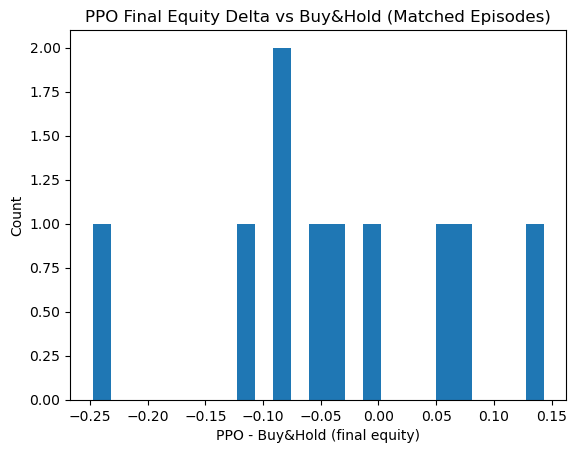

In [11]:
plt.figure()
plt.hist(pivot["delta_eq_vs_buyhold"].values, bins=25)
plt.title("PPO Final Equity Delta vs Buy&Hold (Matched Episodes)")
plt.xlabel("PPO - Buy&Hold (final equity)")
plt.ylabel("Count")
plt.show()

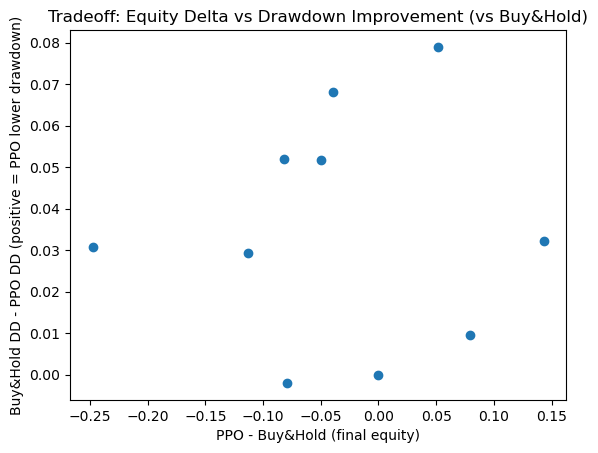

In [12]:
plt.figure()
plt.scatter(pivot["delta_eq_vs_buyhold"].values, pivot["dd_improve_vs_buyhold"].values)
plt.title("Tradeoff: Equity Delta vs Drawdown Improvement (vs Buy&Hold)")
plt.xlabel("PPO - Buy&Hold (final equity)")
plt.ylabel("Buy&Hold DD - PPO DD (positive = PPO lower drawdown)")
plt.show()

## Classify failure modes

We label PPO outcomes into interpretable categories:

- Missed trend (too conservative)
- Tradeoff: lower risk, lower return
- Bad timing or instability
- OK / not a failure

This converts raw metrics into explanations.

In [13]:
def label_failure(row) -> str:
    # PPO loses equity:
    eq_loss = row["delta_eq_vs_buyhold"] < -0.05

    # PPO also doesn't reduce drawdown:
    no_dd = row["dd_improve_vs_buyhold"] < 0.02

    # PPO is too flat / not trend capturing: slope much worse than buy_hold
    slope_gap = row["eq_slope__ppo"] - row["eq_slope__buy_hold"]
    too_flat = slope_gap < -1e-4  # heuristic; adjust if needed

    if eq_loss and no_dd and too_flat:
        return "Missed trend (too conservative)"
    if eq_loss and no_dd and not too_flat:
        return "Bad timing / noisy policy"
    if eq_loss and not no_dd:
        return "Tradeoff: lower risk, lower return"
    return "OK / not a failure"

pivot["failure_mode"] = pivot.apply(label_failure, axis=1)

pivot["failure_mode"].value_counts()

failure_mode
OK / not a failure                    6
Tradeoff: lower risk, lower return    3
Missed trend (too conservative)       1
Name: count, dtype: int64

## Symbol-level performance analysis

We aggregate failures by symbol to answer:
- Does PPO fail broadly or only on specific names?
- Are failures concentrated in certain market regimes?

This helps distinguish model limitations from data idiosyncrasies.

In [14]:
fm = (
    pivot.groupby("failure_mode")
         .agg(n=("pair_key","count"),
              mean_delta_eq=("delta_eq_vs_buyhold","mean"),
              mean_dd_improve=("dd_improve_vs_buyhold","mean"))
         .reset_index()
         .sort_values("n", ascending=False)
)
fm

,failure_mode,n,mean_delta_eq,mean_dd_improve
1,OK / not a failure,6,0.030949,0.040098
2,"Tradeoff: lower risk, lower return",3,-0.147363,0.037318
0,Missed trend (too conservative),1,-0.079171,-0.002028


## Improvement hypotheses (what to try next)

Based on matched evaluation, PPO tends to fail in a few predictable ways:

1) **Missed trends (too conservative)**
   - PPO underperforms buy&hold without materially reducing drawdown.
   - Likely causes: reward shaping discourages exposure, weak trend features, coarse action space.

2) **Tradeoff: lower risk, lower return**
   - PPO loses equity but improves drawdown.
   - This may be acceptable depending on objective; otherwise adjust reward to value growth more.

3) **Bad timing / policy instability**
   - PPO behavior appears inconsistent across seeds/windows on the same symbol.
   - Likely causes: short training horizon, insufficient exploration, unstable learning rate/entropy.

Next sprint, we convert these into controlled experiments (one change at a time).

## Sprint 5: Ranked experiments (do in order)

**Tier 1 (highest leverage, lowest risk)**
1) Increase training horizon (e.g., 200k → 1M timesteps) and evaluate again.
2) Add a “trend/volatility context” feature set:
   - rolling returns (5/10/20)
   - rolling vol (10/20)
   - price vs moving averages (ratio features)

**Tier 2 (objective shaping)**
3) Reward shaping: combine growth + risk:
   - reward = log_return - lambda * drawdown_delta
   - or penalize large exposure during high vol / earnings window

**Tier 3 (policy expressiveness)**
4) Expand action space (e.g., [0, .25, .5, .75, 1]) or add a “reduce exposure” action
5) Add light transaction cost or switching penalty to prevent thrashing

Each change must be evaluated with the same matched protocol used in Sprint 4.

In [15]:
from pathlib import Path
import numpy as np

# --- Resolve repo root robustly ---
ROOT = Path.cwd().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

# --- UI public artifacts dir (source of truth for dashboard) ---
UI_OUT = ROOT / "ui" / "earningsedge-dashboard" / "public" / "artifacts" / "sprint4"
UI_OUT.mkdir(parents=True, exist_ok=True)

# --- Expect these objects exist from earlier cells in the notebook ---
# sym_summary: symbol-level summary df
# fm: failure-mode summary df (optional)
# pivot: episode-level deltas df (optional)
#
# If your variable names differ, rename them right above this export cell.

# 1) Ensure integer failures exists (do NOT rely on fail_rate * n_pairs)
# If you have a per-pair flag column like `fail` in the underlying data,
# compute failures directly. Otherwise fall back safely.

if "failures" not in sym_summary.columns:
    # If you have a boolean/0-1 column named "fail" in the source you grouped, do this instead:
    # sym_summary = source_df.groupby("symbol").agg(
    #     n_pairs=("pair_key","count"),
    #     failures=("fail","sum"),
    #     ...
    # ).reset_index()

    # fallback (keeps you unblocked):
    sym_summary["failures"] = np.where(
        sym_summary[["n_pairs","fail_rate"]].notnull().all(axis=1),
        np.round(sym_summary["n_pairs"] * sym_summary["fail_rate"]).astype(int),
        np.nan
    )

# 2) Recompute fail_rate from failures / n_pairs (clean + consistent)
sym_summary["fail_rate"] = np.where(
    sym_summary["n_pairs"] > 0,
    sym_summary["failures"] / sym_summary["n_pairs"],
    np.nan
)

# 3) Add `reason` column if it doesn't exist (optional but helps UI)
if "reason" not in sym_summary.columns:
    sym_summary["reason"] = ""

# --- Write UI-facing CSVs ---
sym_path = UI_OUT / "symbol_failure_summary.csv"
sym_summary.to_csv(sym_path, index=False)

# Optional exports if they exist
fm_path = None
if "fm" in globals():
    fm_path = UI_OUT / "failure_mode_summary.csv"
    fm.to_csv(fm_path, index=False)

pivot_path = None
if "pivot" in globals():
    pivot_path = UI_OUT / "episode_level_deltas.csv"
    pivot.to_csv(pivot_path, index=False)

print("Saved:", sym_path)
if fm_path: print("Saved:", fm_path)
if pivot_path: print("Saved:", pivot_path)

Saved: /home/btheard/projects/earningsedge-rl/ui/earningsedge-dashboard/public/artifacts/sprint4/symbol_failure_summary.csv
Saved: /home/btheard/projects/earningsedge-rl/ui/earningsedge-dashboard/public/artifacts/sprint4/failure_mode_summary.csv
Saved: /home/btheard/projects/earningsedge-rl/ui/earningsedge-dashboard/public/artifacts/sprint4/episode_level_deltas.csv
